In [30]:
import json

file_path = "../Data/chat_finetune.json"
with open(file_path, "r",encoding='utf-8') as file:
    data = json.load(file)

In [31]:
len(data)

3844

In [32]:
import sys
sys.path.append('..')

In [33]:
from minbpe import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer.load(model_file="../Data/tokenizer/my_tokenizer.model")


def get_vocab_size(tokenizer: RegexTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

In [34]:
tokenized_data = []
for item in data:
    tokenized_item = tokenizer.encode(item, allowed_special="all")
    tokenized_data.append(tokenized_item)

len(tokenized_data[0])

21

In [35]:
initial_split_index = int(0.95 * len(data))

# Adjusting the index to ensure that the training set ends with "Assistant" message
# and that the validation set starts with "You" message

# Scanning backward to find an Assistant message
split_index = initial_split_index
while split_index > 0 and not data[split_index-1].startswith('<|startoftext|>Assistant'):
    split_index -= 1

train_data = data[:split_index]
val_data = data[split_index:]

print("Training set: ")
print(f"Start message: {train_data[0].split('<|separator|>')[0]}")
print(f"End message: {train_data[-1].split('<|separator|>')[0]}")

print("\nValidation set: ")
print(f"Start message: {val_data[0].split('<|separator|>')[0]}")
print(f"End message: {val_data[-1].split('<|separator|>')[0]}")

Training set: 
Start message: <|startoftext|>You 
End message: <|startoftext|>Assistant 

Validation set: 
Start message: <|startoftext|>You 
End message: <|startoftext|>Assistant 


In [36]:
train_data = tokenized_data[:split_index]
val_data = tokenized_data[split_index:]

In [37]:
block_size = 512


def combine_turns(data: list[list[int]], should_trim_long_sequences: bool) -> list[list[int]]:
    combined_turns_data = []
    for i in range(0, len(data)-1, 2):
        you_message = data[i]
        assistant_message = data[i+1]
        if not you_message or not assistant_message:
            continue

        final_message = you_message + assistant_message
        if len(final_message) > block_size and should_trim_long_sequences:
            final_message = final_message[-block_size:]

        combined_turns_data.append(final_message)
    return combined_turns_data


combined_train_data = combine_turns(
    data=train_data,
    should_trim_long_sequences=True
)
combined_val_data = combine_turns(
    data=val_data,
    should_trim_long_sequences=True
)

In [38]:
print("Train data")
print(f"Length before: {len(train_data)}")
print(f"Length after: {len(combined_train_data)}")

print("\nValidation data")
print(f"Length before: {len(val_data)}")
print(f"Length after: {len(combined_val_data)}")

Train data
Length before: 3650
Length after: 1825

Validation data
Length before: 194
Length after: 97


In [39]:
import torch

train_data = torch.tensor(combined_train_data)
val_data = torch.tensor(combined_val_data)

ValueError: expected sequence of length 47 at dim 1 (got 53)

In [40]:
import torch
torch.manual_seed(3647)

# The token `<|padding|>` is used to mask the padding tokens.
# Masking means the model will ignore these tokens during training.
# In other words, the loss will not be calculated for these tokens.
padding_token = tokenizer.special_tokens["<|padding|>"]


def apply_padding_to_data(data: list[list[int]], block_size: int, padding_token: int) -> torch.Tensor:
    tensors = []
    for i in range(len(data)):
        tensor = torch.tensor(data[i])
        padded_tensor = torch.nn.functional.pad(
            input=tensor,
            # for right padding:
            pad=(0, block_size - len(tensor)),
            # pad=(block_size - len(tensor), 0),
            value=padding_token
        )
        tensors.append(padded_tensor)

    return torch.stack(tensors)


train_data_tensor = apply_padding_to_data(
    data=combined_train_data,
    block_size=block_size,
    padding_token=padding_token
)
val_data_tensor = apply_padding_to_data(
    data=combined_val_data,
    block_size=block_size,
    padding_token=padding_token
)

train_data_tensor.shape, val_data_tensor.shape

(torch.Size([1825, 512]), torch.Size([97, 512]))

In [41]:
train_data_tensor[0]

tensor([2492,   89,  260,   32, 2493,   32,  462,   44,   32,  104,  293,   32,
         280,  101,   32,  266,   32,  345,  279,   63, 2494, 2492,   65,  115,
         581,  304, 1167,   32, 2493,   32,  105,   39,  109,   32,  835,  101,
          46,   32,  104,  293,   32,  343,  765,   32, 1759,   63, 2494, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 24

In [42]:
val_data_tensor[0]

tensor([2492,   89,  260,   32, 2493,   32, 1864,   32,  497,  323,  116,   32,
         407,  116,   32,  363,   32, 1639,   32,  266,   32,  111,  676,   46,
        2494, 2492,   65,  115,  581,  304, 1167,   32, 2493,   32, 1864,   32,
         497,  323,  116,   32,  740,   32,  105,   39,  109,   32,  544,   46,
        2494, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 24

In [43]:
train_data_tensor.shape

torch.Size([1825, 512])

In [44]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class FineTuningDataset(Dataset):
    def __init__(self, data: torch.Tensor, device: torch.device, padding_token: int):
        self.data = data  # shape: (num_samples, block_size)
        self.device = device
        self.padding_token = padding_token

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        sample = self.data[index]
        x = sample.to(self.device)
        y = sample[1:].to(self.device)
        padding_tensor = torch.tensor([self.padding_token], device=self.device)
        y = torch.cat((y, padding_tensor))
        return x, y


batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = FineTuningDataset(
    data=train_data_tensor,
    device=device,
    padding_token=padding_token
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = FineTuningDataset(
    data=val_data_tensor,
    device=device,
    padding_token=padding_token
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [45]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([32, 512]), torch.Size([32, 512]))

In [48]:
from transformer.model import GPTLanguageModel

block_size = 512
n_embd = 128
n_head = 8
n_layer = 1
dropout = 0.2
batch_size = 32
vocab_size = get_vocab_size(tokenizer)

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device,
    ignore_index=tokenizer.special_tokens["<|padding|>"],
).to(device)
model = torch.compile(model)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

0.906694 M parameters


In [49]:
checkpoint_path = "../Data/pre_training/run_1/checkpoint_2.pth"
checkpoint = torch.load(checkpoint_path, weights_only=True)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [51]:
input_tokens = tokenizer.encode("hi, how are you doing? ", allowed_special="all")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))

hi, how are you doing? noring. you should be horin the front way, and they were dred e, but not sure. why did what? and then shoup ever. i found a new hard driversing that won't should stod's party your land takes about five fenot sure. hours, no care of you to think i'm going to tell me. then they'll give him dollars and can, please don't ask me. you go to the classroom? yes, i am out? i have no idea. don't you go to college did you get divorced? it's oken. boss the news? some money. ohout right now


In [52]:
from typing import Dict


@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = []
        for x, y in loader:
            with torch.no_grad():
                _, loss = model(x, y)
            losses.append(loss.item())
        output[split] = sum(losses) / len(losses)

    model.train()
    return output

In [53]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

In [54]:
import os
import warnings

# --- Disable Triton checks ---
os.environ["TORCHINDUCTOR_DISABLE_TRITON"] = "1"

# --- Suppress TorchDynamo / Inductor warnings ---
warnings.filterwarnings("ignore", category=UserWarning)

# Optional: fully disable TorchDynamo verbose logging
import torch._dynamo as dynamo
dynamo.reset()
dynamo.config.verbose = 0
dynamo.config.suppress_errors = True

In [59]:
max_iters = 10
eval_interval = 10
learning_rate = 6e-5

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        # Evaluation
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
            losses = estimate_loss(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
            )
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

            print(
                f"iteration {iteration} / step {batch_idx}: "
                f"train loss {losses['train']:.4f}, "
                f"val loss {losses['val']:.4f}"
            )

        # Training step
        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # Save checkpoint
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=iteration,
        loss=loss.item(),
        file_path=f"../Data/fine_tuning/run_3/checkpoint_{iteration}.pth"
    )

iteration 0 / step 0: train loss 3.1998, val loss 3.3947
iteration 0 / step 10: train loss 3.1211, val loss 3.3355
iteration 0 / step 20: train loss 3.0542, val loss 3.2510
iteration 0 / step 30: train loss 2.9857, val loss 3.1924
iteration 0 / step 40: train loss 2.9316, val loss 3.1576
iteration 0 / step 50: train loss 2.8756, val loss 3.1039
iteration 0 / step 57: train loss 2.8343, val loss 3.0715
iteration 1 / step 0: train loss 2.8338, val loss 3.0694
iteration 1 / step 10: train loss 2.8069, val loss 3.0397
iteration 1 / step 20: train loss 2.7680, val loss 2.9953
iteration 1 / step 30: train loss 2.7089, val loss 2.9456
iteration 1 / step 40: train loss 2.6685, val loss 2.9042
iteration 1 / step 50: train loss 2.6263, val loss 2.8745
iteration 1 / step 57: train loss 2.6157, val loss 2.8577
iteration 2 / step 0: train loss 2.5978, val loss 2.8478
iteration 2 / step 10: train loss 2.5866, val loss 2.8285
iteration 2 / step 20: train loss 2.5522, val loss 2.7994
iteration 2 / ste

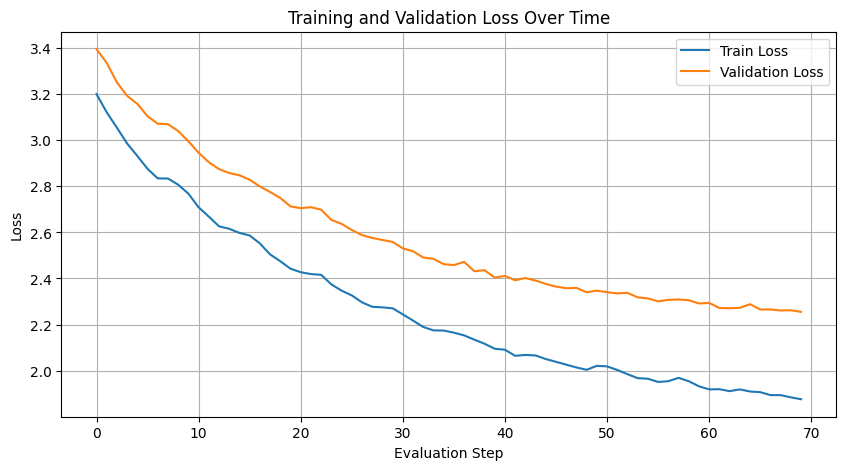

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [69]:
def get_input_tokens(message: str) -> torch.Tensor:
    input_tokens = tokenizer.encode(
        f"<|startoftext|>{message}<|separator|>", allowed_special="all")
    input_tokens = torch.tensor(
        input_tokens, dtype=torch.long).unsqueeze(0).to(device)
    return input_tokens


user_message = "hi, how are you doing?"
input_tokens = get_input_tokens(message=user_message)
model_answer = ""

model.eval()
while True:
    output_tokens = model.generate(input_tokens=input_tokens, max_new_tokens=1)
    last_generated_token = output_tokens[0, -1].item()
    if last_generated_token == tokenizer.special_tokens["<|endoftext|>"]:
        break

    input_tokens = torch.cat((input_tokens, output_tokens[:, -1:]), dim=1)
    model_answer += tokenizer.decode([last_generated_token])

    if len(output_tokens[0]) > block_size:
        input_tokens = input_tokens[:, -block_size:]

print(f"You: {user_message}")
print(f"Assistant: {model_answer}")

You: hi, how are you doing?
Assistant:  up we school thought it's years be is wantpoor to for?
